* https://github.com/SKTBrain/KoBERT

In [ ]:
# requirements.txt
"""
boto3
gluonnlp >= 0.6.0
mxnet >= 1.4.0
onnxruntime == 0.3.0
sentencepiece >= 0.1.6
torch >= 1.7.0
transformers >= 4.8.1
"""

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import gluonnlp as nlp

from tqdm import tqdm

In [ ]:
from kobert import get_tokenizer
from kobert import get_pytorch_kobert_model

In [ ]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# GPU 사용 시
device = torch.device("cuda:0")
print(device)

bertmodel, vocab = get_pytorch_kobert_model()

cuda:0
/db/1622817/jun_space/ML study/KoBERT/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/db/1622817/jun_space/ML study/KoBERT/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [ ]:
import os
os.getcwd()

'/db/1622817/jun_space/ML study/KoBERT'

In [ ]:
PATH = 'jun_space/ML study/dataset/Kobert/'

In [ ]:
df = pd.read_csv(PATH + '전처리.csv')
print(df.shape)
df.sample(5)

(140625, 3)


,Sentence,Emotion,Cleaned
13503,무언가 매혹적이면서도 딱 무엇이라 정의할 단어가 떠오르지 않는다. 재미가 있다 라고...,1,무언가 매혹적이면서도 무엇이라 정의할 단어가 떠오르지 않는다 재미가 라고 말 하기엔...
135329,운 좋은 거 맞을까.,0,운 좋은 거 맞을까
92505,이래서 외교에 영원한 우방이란 없다고 하는거지.,0,이래서 외교에 영원한 우방이란 없다고 하는거지
29809,처음부터 잊혀지지 않는 ost . 머리를 통한 이해는 영화를 보는 데 방해만 될 듯,1,처음부터 잊혀지지 않는 머리를 통한 이해는 영화를 보는 데 방해만 될 듯
126993,배부른데.,0,배부른데


In [ ]:
# 텍스트 중에 string이 아닌 것이 있음
df['Cleaned'] = df['Cleaned'].astype(str)
type(df['Cleaned'][0])

str

문장 최대 길이: 299
문장 평균 길이: 0.005006222222222222


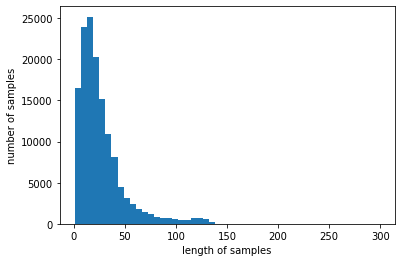

In [ ]:
print('문장 최대 길이: {}'.format(max(len(str(sample)) for sample in df['Cleaned'])))
print('문장 평균 길이: {}'.format(sum(map(len, str(df['Cleaned']))) / len(df['Cleaned'])))

plt.hist([len(str(sample)) for sample in df['Cleaned']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 밑에서 BERTDataset을 사용하기 위해 어레이로 변환
new_df = df[['Cleaned', 'Emotion']].values # np.array()
new_df[0]

array(['유재석 오라버니 해피투게더 봤어요', 1], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(new_df, test_size=0.15, random_state=42, stratify=df['Emotion'])
print("train shape is:", len(train))
print("test shape is:", len(test))

train shape is: 119531
test shape is: 21094


In [ ]:
# 기본 Bert tokenizer 사용
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /db/1622817/jun_space/ML study/KoBERT/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
class BERTDataset(Dataset):
  def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                pad, pair):
    transform = nlp.data.BERTSentenceTransform(
        bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair) 

    self.sentences = [transform([i[sent_idx]]) for i in dataset]
    self.labels = [np.int32(i[label_idx]) for i in dataset]

  def __getitem__(self, i):
    return (self.sentences[i] + (self.labels[i], ))

  def __len__(self):
    return (len(self.labels))

In [ ]:
# Setting parameters
max_len = 128 # 해당 길이를 초과하는 단어에 대해선 bert가 학습하지 않음
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

In [ ]:
data_train = BERTDataset(train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(test, 0, 1, tok, max_len, True, False)

# pytorch용 DataLoader 사용
train_dataloader = DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = DataLoader(data_test, batch_size=batch_size, num_workers=5)

In [ ]:
class BERTClassifier(nn.Module):
  def __init__(self,
                bert,
                hidden_size = 768,
                num_classes = 3, # softmax 사용 <- binary일 경우는 2
                dr_rate=None,
                params=None):
    
    super(BERTClassifier, self).__init__()
    self.bert = bert
    self.dr_rate = dr_rate
              
    self.classifier = nn.Linear(hidden_size , num_classes)
    if dr_rate:
      self.dropout = nn.Dropout(p=dr_rate)
  
  def gen_attention_mask(self, token_ids, valid_length):
    attention_mask = torch.zeros_like(token_ids)
    for i, v in enumerate(valid_length):
      attention_mask[i][:v] = 1
    return attention_mask.float()

  def forward(self, token_ids, valid_length, segment_ids):
    attention_mask = self.gen_attention_mask(token_ids, valid_length)
    
    _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
    if self.dr_rate:
      out = self.dropout(pooler)
    return self.classifier(out)
      
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01}, # 'bias', 'LayerNorm.weight' 둘 중 하나라도 포함되지 않으면 weight_deacy=0.01
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0} # 'bias', 'LayerNorm.weight' 둘 다 model.named_parameters()에 포함되면 weight_decay=0
]

# 위의 한 줄 풀어쓰기
# for n, p in model.named_parameters():
#     for nd in no_deacy:
#         if not any(nd in n):
#             [p]

In [ ]:
# 옵티마이저 선언
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # softmax용 Loss Function 정하기 <- binary classification도 해당 loss function 사용 가능

In [ ]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
# 학습 평가 지표인 accuracy 계산 -> 얼마나 타겟값을 많이 맞추었는가
def calc_accuracy(X,Y):
  max_vals, max_indices = torch.max(X, 1)
  train_acc = (max_indices == Y).sum().data.cpu().numpy() / max_indices.size()[0]
  return train_acc

In [ ]:
# 모델 학습 시작
for e in range(num_epochs):
  train_acc = 0.0
  test_acc = 0.0
  model.train()
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
    optimizer.zero_grad()

    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    label = label.long().to(device)

    out = model(token_ids, valid_length, segment_ids)

    loss = loss_fn(out, label)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm) # gradient clipping

    optimizer.step()
    scheduler.step() # Update learning rate schedule
    train_acc += calc_accuracy(out, label)

    if batch_id % log_interval == 0:
      print("epoch {} batch id {} loss {} train acc {}".format(e + 1, batch_id + 1, loss.data.cpu().numpy(), train_acc / (batch_id + 1)))
    
    # 추후 학습 재개를 위해 필요한 정보 저장
#     torch.save({
#       'epoch': epoch,
#       'optimizer_state_dict': optimizer.state_dict(),
#       'model_state_dict': model.state_dict(),
#       'scheduler': scheduler.state_dict(),
#       'loss': loss
#     }, base_dir + f'_{epoch:04d}.pth')

  print("epoch {} train acc {}".format(e + 1, train_acc / (batch_id + 1)))

  0%|          | 1/1868 [00:01<31:12,  1.00s/it]

epoch 1 batch id 1 loss 0.2048843950033188 train acc 0.9375


 11%|█         | 201/1868 [01:28<12:14,  2.27it/s]

epoch 1 batch id 201 loss 0.25776758790016174 train acc 0.9510261194029851


 21%|██▏       | 401/1868 [02:57<10:49,  2.26it/s]

epoch 1 batch id 401 loss 0.2087821215391159 train acc 0.9500467581047382


 32%|███▏      | 601/1868 [04:25<09:22,  2.25it/s]

epoch 1 batch id 601 loss 0.2424100935459137 train acc 0.9515650998336106


 43%|████▎     | 801/1868 [05:54<07:53,  2.25it/s]

epoch 1 batch id 801 loss 0.13704341650009155 train acc 0.9519155742821473


 54%|█████▎    | 1001/1868 [07:22<06:23,  2.26it/s]

epoch 1 batch id 1001 loss 0.06696699559688568 train acc 0.9519230769230769


 64%|██████▍   | 1201/1868 [08:51<04:55,  2.26it/s]

epoch 1 batch id 1201 loss 0.24186047911643982 train acc 0.9527347002497918


 75%|███████▌  | 1401/1868 [10:20<03:26,  2.26it/s]

epoch 1 batch id 1401 loss 0.1063297688961029 train acc 0.952935403283369


 86%|████████▌ | 1601/1868 [11:48<01:58,  2.26it/s]

epoch 1 batch id 1601 loss 0.0924442857503891 train acc 0.9528126951905059


 96%|█████████▋| 1801/1868 [13:17<00:29,  2.26it/s]

epoch 1 batch id 1801 loss 0.10043050348758698 train acc 0.9522487506940589


100%|██████████| 1868/1868 [13:47<00:00,  2.26it/s]


epoch 1 train acc 0.9522342715128729


  0%|          | 1/1868 [00:01<31:52,  1.02s/it]

epoch 2 batch id 1 loss 0.2856529951095581 train acc 0.890625


 11%|█         | 201/1868 [01:29<12:18,  2.26it/s]

epoch 2 batch id 201 loss 0.22572115063667297 train acc 0.9455068407960199


 21%|██▏       | 401/1868 [02:58<10:52,  2.25it/s]

epoch 2 batch id 401 loss 0.19240665435791016 train acc 0.946267144638404


 32%|███▏      | 601/1868 [04:27<09:22,  2.25it/s]

epoch 2 batch id 601 loss 0.3196406364440918 train acc 0.9474833610648918


 43%|████▎     | 801/1868 [05:55<07:53,  2.25it/s]

epoch 2 batch id 801 loss 0.14429576694965363 train acc 0.9485994069912609


 54%|█████▎    | 1001/1868 [07:24<06:24,  2.26it/s]

epoch 2 batch id 1001 loss 0.0651778057217598 train acc 0.9485046203796204


 64%|██████▍   | 1201/1868 [08:53<04:55,  2.26it/s]

epoch 2 batch id 1201 loss 0.2010831981897354 train acc 0.949169962531224


 75%|███████▌  | 1401/1868 [10:21<03:27,  2.25it/s]

epoch 2 batch id 1401 loss 0.11821572482585907 train acc 0.9495672733761599


 86%|████████▌ | 1601/1868 [11:50<01:58,  2.25it/s]

epoch 2 batch id 1601 loss 0.10959187150001526 train acc 0.949416380387258


 96%|█████████▋| 1801/1868 [13:19<00:29,  2.25it/s]

epoch 2 batch id 1801 loss 0.10323628783226013 train acc 0.9490474042198779


100%|██████████| 1868/1868 [13:49<00:00,  2.25it/s]


epoch 2 train acc 0.9489763722548678


  0%|          | 1/1868 [00:01<31:21,  1.01s/it]

epoch 3 batch id 1 loss 0.21579866111278534 train acc 0.921875


 11%|█         | 201/1868 [01:29<12:18,  2.26it/s]

epoch 3 batch id 201 loss 0.24670669436454773 train acc 0.945429104477612


 21%|██▏       | 401/1868 [02:58<10:49,  2.26it/s]

epoch 3 batch id 401 loss 0.23895768821239471 train acc 0.9452540523690773


 32%|███▏      | 601/1868 [04:27<09:22,  2.25it/s]

epoch 3 batch id 601 loss 0.22549767792224884 train acc 0.9459234608985025


 43%|████▎     | 801/1868 [05:56<07:52,  2.26it/s]

epoch 3 batch id 801 loss 0.16231194138526917 train acc 0.9460635143570537


 54%|█████▎    | 1001/1868 [07:24<06:25,  2.25it/s]

epoch 3 batch id 1001 loss 0.09690988808870316 train acc 0.9461788211788211


 64%|██████▍   | 1201/1868 [08:53<04:59,  2.23it/s]

epoch 3 batch id 1201 loss 0.4347839057445526 train acc 0.9464508742714405


 75%|███████▌  | 1401/1868 [10:22<03:27,  2.25it/s]

epoch 3 batch id 1401 loss 0.124654620885849 train acc 0.9463998929336188


 86%|████████▌ | 1601/1868 [11:51<01:58,  2.26it/s]

epoch 3 batch id 1601 loss 0.05722328647971153 train acc 0.9462640537164272


 96%|█████████▋| 1801/1868 [13:20<00:29,  2.25it/s]

epoch 3 batch id 1801 loss 0.21237558126449585 train acc 0.9460108967240421


100%|██████████| 1868/1868 [13:49<00:00,  2.25it/s]


epoch 3 train acc 0.9458645610278372


  0%|          | 1/1868 [00:01<31:57,  1.03s/it]

epoch 4 batch id 1 loss 0.23007431626319885 train acc 0.90625


 11%|█         | 201/1868 [01:29<12:19,  2.25it/s]

epoch 4 batch id 201 loss 0.2981634736061096 train acc 0.9419309701492538


 21%|██▏       | 401/1868 [02:58<10:51,  2.25it/s]

epoch 4 batch id 401 loss 0.22519446909427643 train acc 0.9427213216957606


 32%|███▏      | 601/1868 [04:27<09:22,  2.25it/s]

epoch 4 batch id 601 loss 0.2781173586845398 train acc 0.94238768718802


 43%|████▎     | 801/1868 [05:55<07:55,  2.24it/s]

epoch 4 batch id 801 loss 0.15175698697566986 train acc 0.9423377028714107


 54%|█████▎    | 1001/1868 [07:24<06:25,  2.25it/s]

epoch 4 batch id 1001 loss 0.13253159821033478 train acc 0.9422608641358642


 64%|██████▍   | 1201/1868 [08:53<04:56,  2.25it/s]

epoch 4 batch id 1201 loss 0.3090742528438568 train acc 0.9428340965861782


 75%|███████▌  | 1401/1868 [10:22<03:27,  2.25it/s]

epoch 4 batch id 1401 loss 0.11441253125667572 train acc 0.9428756245538901


 86%|████████▌ | 1601/1868 [11:51<01:58,  2.25it/s]

epoch 4 batch id 1601 loss 0.07387039810419083 train acc 0.9430238913179263


 96%|█████████▋| 1801/1868 [13:20<00:29,  2.25it/s]

epoch 4 batch id 1801 loss 0.14141525328159332 train acc 0.9425839811215991


100%|██████████| 1868/1868 [13:50<00:00,  2.25it/s]


epoch 4 train acc 0.9425483043673124


  0%|          | 1/1868 [00:01<31:25,  1.01s/it]

epoch 5 batch id 1 loss 0.09386042505502701 train acc 0.96875


 11%|█         | 201/1868 [01:29<12:21,  2.25it/s]

epoch 5 batch id 201 loss 0.25063949823379517 train acc 0.939521144278607


 21%|██▏       | 401/1868 [02:58<10:50,  2.26it/s]

epoch 5 batch id 401 loss 0.263238787651062 train acc 0.9394872194513716


 32%|███▏      | 601/1868 [04:27<09:28,  2.23it/s]

epoch 5 batch id 601 loss 0.2042059749364853 train acc 0.9405418053244592


 43%|████▎     | 801/1868 [05:56<07:54,  2.25it/s]

epoch 5 batch id 801 loss 0.08599235117435455 train acc 0.9407381398252185


 54%|█████▎    | 1001/1868 [07:26<06:33,  2.20it/s]

epoch 5 batch id 1001 loss 0.14871269464492798 train acc 0.9419018481518482


 64%|██████▍   | 1201/1868 [08:55<04:55,  2.26it/s]

epoch 5 batch id 1201 loss 0.20566558837890625 train acc 0.9425738967527061


 75%|███████▌  | 1401/1868 [10:24<03:26,  2.26it/s]

epoch 5 batch id 1401 loss 0.049175966531038284 train acc 0.9428533190578159


 86%|████████▌ | 1601/1868 [11:53<01:58,  2.25it/s]

epoch 5 batch id 1601 loss 0.0992196798324585 train acc 0.9431410056214866


 96%|█████████▋| 1801/1868 [13:21<00:29,  2.25it/s]

epoch 5 batch id 1801 loss 0.1047637090086937 train acc 0.9434862576346474


100%|██████████| 1868/1868 [13:51<00:00,  2.25it/s]

epoch 5 train acc 0.9435351280439221


In [ ]:
# 학습 가능한 매개변수가 담겨있는 딕셔너리(Dictionary), 가중치와 편향이 이에 해당
torch.save(model.state_dict(), PATH + 'model_state.pt') # 또 다른 확장자명: .pth

In [ ]:
# 모델 전체 저장: 모델 파라미터 뿐만 아니라, 옵티마이저(Optimizer), 에포크, 스코어 등 모든 상태를 저장
torch.save(model, PATH + 'model.pt')